# 模型选择，过拟合和欠拟合
验证数据集的意义在于从训练误差估计泛化误差
## 多项式函数拟合实验 

In [1]:
%matplotlib inline
import torch
import numpy as np

### 0 生成数据集
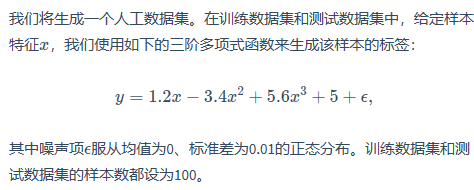

In [8]:
n_train,n_test,true_w,true_b = 100, 100,[1.2, -3.4, 5.6], 5
features = torch.randn((n_train+n_test,1))
poly_features = torch.cat((features,torch.pow(features,2),torch.pow(features,3)),1)
labels = torch.mm(poly_features,torch.tensor([true_w]).T)+true_b + torch.tensor(np.random.normal(0,0.01,size = (n_train+n_test,1)),dtype=torch.float)

In [3]:
features.shape,poly_features.shape

(torch.Size([200, 1]), torch.Size([200, 3]))

In [12]:
num_epochs,loss = 100,torch.nn.MSELoss()
def fit_and_plot(train_features,test_features,train_labels,test_labels):
    net=torch.nn.Linear(train_features.shape[-1],1)
    batch_size = min(10,train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)
    
    optimizer = torch.optim.SGD(net.parameters(),lr=0.01)
    train_ls,test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y.view(-1,1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1,1)
        test_labels = test_labels.view(-1,1)
        train_ls.append(loss(net(train_features),train_labels).item())
        test_ls.append(loss(net(test_features),test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    print('weight:', net.weight.data,'\nbias:', net.bias.data)

In [13]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],labels[:n_train], labels[n_train:])

final epoch: train loss 0.00011635798728093505 test loss 9.404785669175908e-05
weight: tensor([[ 1.2025, -3.3990,  5.5991]]) 
bias: tensor([4.9991])


## 高维线性回归实验
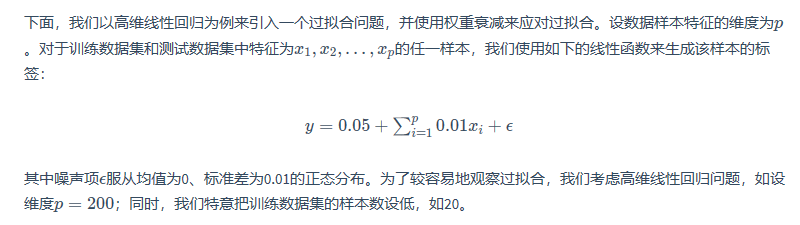

In [16]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
n_train,n_test,num_inputs = 20, 100, 200
true_w,true_b = torch.ones(num_inputs,1)*0.01,0.05
features = torch.randn((n_train+n_test,num_inputs))
labels = torch.mm(features,true_w)+true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.shape))
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [17]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = d2l.linreg, d2l.squared_loss

dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

def fit_and_plot_pytorch(wd):
    # 对权重参数衰减。权重名称一般是以weight结尾
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd) # 对权重参数衰减
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)  # 不对偏差参数衰减

    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()

            l.backward()

            # 对两个optimizer实例分别调用step函数，从而分别更新权重和偏差
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    print('L2 norm of w:', net.weight.data.norm().item())

NameError: name 'd2l' is not defined

# Dropout
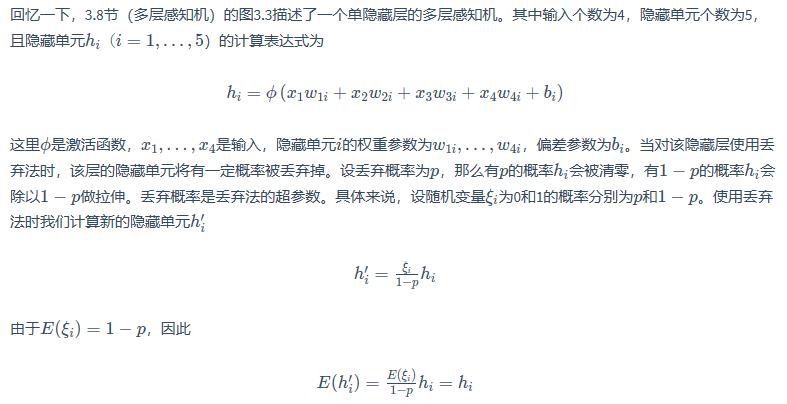
**<font color='red'>丢弃法不改变其输入的期望值</font>**
## Pytorch实现
在全连接层后添加**<font color='orange'>Dropout</font>**层并丢弃概率。在训练模型时，**<font color='orange'>Dropout</font>**层将以指定的丢弃概率随机丢弃上一层的输出元素；在测试模型时（即**<font color='orange'>model.eval()</font>**后），**<font color='orange'>Dropout</font>**层并不发挥作用。

In [19]:
drop_prob1, drop_prob2 = 0.2, 0.5
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

net = nn.Sequential(
    nn.Linear(num_inputs,num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1,num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2,10)
)
for param in net.parameters():
    nn.init.normal_(param,mean=0,std=0.01)

In [ ]:
optimizer = torch.optim.SGD(net.parameters(),lr=0.5)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)